In [1]:
from collections.abc import Callable
from typing import Optional
import numpy as np
import pandas as pd

In [2]:
def RungeKuttaFehlberg45(f: Callable[[np.float64, np.float64], np.float64],
                         t_span: np.ndarray,
                         y_init: np.float64,
                         h_max: Optional[np.float64] = 2.5e-1,
                         h_min: Optional[np.float64] = 1.e-4,
                         tol: Optional[np.float64] = 1.e-10
                         ) -> pd.DataFrame:
    """
    TODO
    ----------
    Approximate first-order IVP ODE of the form

    `y'=f(t,y), y(a)=alpha, a<= t <= b.`

    by adaptive Runge-Kutta-Fehlberg method with order 4 and 5.

    Parameters
    ----------
    `f: callable`
        the function `f(t,y)` on the right-hand side
    `t_span: np.ndarray`
        closed interval `[a, b]`
    `y_init: np.float64`
        initial value of `y`
    `h_max: Optional[np.float64] = 2.5e-1`
        upper threshold for step size `h`
    `h_min: Optional[np.float64] = 1.e-4`
        lower threshold for step size `h`
    `tol: Optional[np.float64] = 1.e-10`
        desire tolerance

    Return
    ----------
    `pd.DataFrame`
        table of `t` and `y`
    Example
    ----------
    >>> def f(t: np.float64, y: np.float64) -> np.float64:
    >>>     return np.float64(y - t**2 + 1)
    >>> t_span = np.array(object=[0., 2.])
    >>> y_init = np.float64(0.5)
    >>> df = RungeKuttaFehlberg45(f=f, t_span=t_span, y_init=y_init, tol=1.e-5)
    >>> def y(t: np.float64) -> np.float64:
    >>>     return (t + 1.)**2. - 0.5*np.exp(t)
    >>> df.loc[:, 'exact'] = df.loc[:, 't'].apply(y)
    >>> df.loc[:, 'error'] = abs(df.loc[:, 'exact']-df.loc[:, 'y'])
    >>> pd.options.display.float_format = "{:.7f}".format
    >>> print(df)
    >>> import matplotlib.pyplot as plt
    >>> figure = plt.figure(figsize=(8, 8))
    >>> axis = figure.add_subplot(211)
    >>> axis.set_title("Runge-Kutta-Fehlberg45")
    >>> axis.plot(df.loc[:, 't'], df.loc[:, 'y'])
    >>> axis2 = figure.add_subplot(212)
    >>> axis2.set_title("Exact Solution")
    >>> axis2.plot(df.loc[:, 't'], df.loc[:, 'exact'])
    >>> plt.show()
    """
    t = t_span[0]
    y = y_init
    h = h_max
    i = 0
    df = pd.DataFrame(data={'t': [t], 'h': [None], 'y': [y]})
    # TODO: Butcher tableau of Runge-Kutta-Fehlberg of order 4 and 5
    c = np.array(object=[0., 1./4., 3./8., 12./13., 1., 1./2.], dtype=np.float64)
    a = np.array(object=[[0., 0., 0., 0., 0.],
                         [1./4., 0., 0., 0., 0.],
                         [3./32., 9./32., 0., 0., 0.],
                         [1932./2197., -7200./2197., 7296./2197., 0., 0.],
                         [439./216., -8., 3680./513., -845./4104., 0.],
                         [-8./27., 2., -3544./2565., 1859./4104., -11./40.]], dtype=np.float64)
    b = np.array(object=[25./216., 0., 1408./2565., 2197./4104., -1./5.], dtype=np.float64)
    # bp = np.array(object=[25./216., 0., 1408./2565., 2197./4104., -1./5., 0.], dtype=np.float64)
    # db = b - bp
    db = np.array(object=[1./360., 0., -128./4275., -2197./75240., 1./50., 2./55.], dtype=np.float64)
    flag = 1
    while flag:
        k0 = f(t, y)
        k1 = f(t + c[1]*h, y + (a[1, 0]*k0)*h)
        k2 = f(t + c[2]*h, y + (a[2, 0]*k0 + a[2, 1]*k1)*h)
        k3 = f(t + c[3]*h, y + (a[3, 0]*k0 + a[3, 1]*k1 + a[3, 2]*k2)*h)
        k4 = f(t + c[4]*h, y + (a[4, 0]*k0 + a[4, 1]*k1 + a[4, 2]*k2 + a[4, 3]*k3)*h)
        k5 = f(t + c[5]*h, y + (a[5, 0]*k0 + a[5, 1]*k1 + a[5, 2]*k2 + a[5, 3]*k3 + a[5, 4]*k4)*h)
        r = abs(db[0]*k0 + db[1]*k1 + db[2]*k2 + db[3]*k3 + db[4]*k4 + db[5]*k5)
        # TODO: Check if the truncation error r is acceptable
        if r <= tol:
            t = t + h
            y = y + (b[0]*k0 + b[1]*k1 + b[2]*k2 + b[3]*k3 + b[4]*k4) * h
            i = i + 1
            df.loc[i, :] = [t, h, y]
        d = 0.84*(tol / r)**(1./4.)
        # TODO: Control the factor d by 0.1 <= h_new / h_old <= 4.0
        if d < 0.1:
            d = 0.1
        elif d > 4.0:
            d = 4.0
        h = d * h
        # TODO: Control h with constraint h <= h_max
        if h > h_max:
            h = h_max
        # TODO: Check if last step reached
        if t >= t_span[1]:
            flag = 0
            print(f':) Successfully completed with {i} steps!')
        elif t + h > t_span[1]:
            h = t_span[1] - t
        # TODO: Check if h is too small
        elif h < h_min:
            flag = 0
            print(f':( At i = {i}, h_i = {h} < h_min = {h_min}.')
    return df

:) Successfully completed with 72 steps!
              t            h            y        exact        error
0  1.0000000000         None 0.0000000000 0.0000000000 0.0000000000
1  1.0071020465 0.0071020465 0.0037623677 0.0037623677 0.0000000000
2  1.0141682320 0.0070661855 0.0073603714 0.0073603714 0.0000000000
3  1.0213305771 0.0071623451 0.0108642373 0.0108642373 0.0000000000
4  1.0285895902 0.0072590131 0.0142732473 0.0142732473 0.0000000000
..          ...          ...          ...          ...          ...
68 1.8961386762 0.0272614447 0.0295021655 0.0295021654 0.0000000000
69 1.9246834840 0.0285448078 0.0260667226 0.0260667225 0.0000000000
70 1.9546984288 0.0300149448 0.0224398513 0.0224398513 0.0000000000
71 1.9864328988 0.0317344700 0.0185985959 0.0185985959 0.0000000000
72 2.0000000000 0.0135671012 0.0169566105 0.0169566105 0.0000000000

[73 rows x 5 columns]


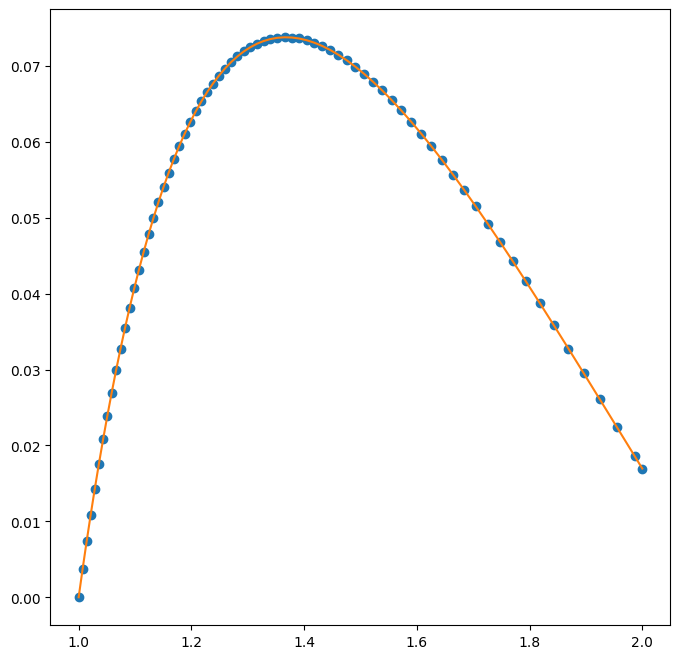

In [3]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt

    def f(t: np.float64, y: np.float64) -> np.float64:
        return t**(-2)*(np.cos(t)-2*t*y)
    t_span = np.array(object=[1, 2], dtype=np.float64)
    y_init = 0.0
    n = 10
    df = RungeKuttaFehlberg45(f=f, t_span=t_span, y_init=y_init)

    def y(t: np.float64) -> np.float64:
        return t**(-2)*(np.sin(t)-np.sin(1))
    df.loc[:, 'exact'] = df.loc[:, 't'].apply(func=y)
    df.loc[:, 'error'] = abs(df.loc[:, 'y']-df.loc[:,'exact'])
    pd.options.display.float_format = '{:.10f}'.format
    print(df)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(df.loc[:,'t'], df.loc[:,'y'], 'o')
    ax.plot(df.loc[:,'t'], df.loc[:,'exact'], '-')
    plt.show()